<a href="https://colab.research.google.com/github/lollcat/annealed_flow_transport/blob/mog_more/craft_gmm_more_settings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/lollcat/annealed_flow_transport.git
import os
os.chdir("annealed_flow_transport")
!git checkout mog_more

fatal: destination path 'annealed_flow_transport' already exists and is not an empty directory.
Already on 'mog_more'
Your branch is up to date with 'origin/mog_more'.


In [ ]:
!pip install chex==0.1.5 ml_collections optax dm-haiku distrax -q

In [ ]:
from annealed_flow_transport.train import run_experiment
from evaluation import make_forward_pass_func, evaluate, load_checkpoint
import numpy as np
import numpy as np
import jax
import ml_collections
ConfigDict = ml_collections.ConfigDict

In [ ]:
from jax.config import config
config.update("jax_enable_x64", True)

In [ ]:
from configs.fab_mog import get_config

In [ ]:
exp_config = get_config()

### Run without pathological initialisation
- changed ` 
annealed_flow_transport/samplers.py` to allow for this. 

In [ ]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

In [ ]:
exp_config.initial_config.diagonal_cov  = 3600. # Big covariance to improve initialisation
exp_config.initial_sampler_config.diagonal_cov = 3600. # Big covariance to improve initialisation
exp_config.batch_size = 512 # Try increase batch size to improve performance.
exp_config.craft_batch_size = 512 # Try increase batch size to improve performance.
exp_config.craft_num_iters = int(10_000_000/128/20) # Long enough to see results. 
exp_config.optimization_config.craft_step_size = 1e-4 # Tried making this much lower (1e-5 but didn't fix things)

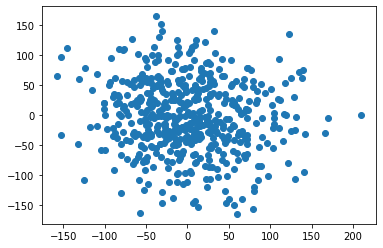

In [ ]:
# We see that the base distribution now completely covers the target.
base_samples = jax.random.normal(jax.random.PRNGKey(0), (exp_config.batch_size, 2)) * jnp.sqrt(exp_config.initial_sampler_config.diagonal_cov)
plt.plot(base_samples[:, 0], base_samples[:, 1], "o")

  0%|          | 0/3906 [00:00<?, ?it/s]

Step 0: Free energy 466.5331607565238 Log Normalizer estimate -0.31504325766494734


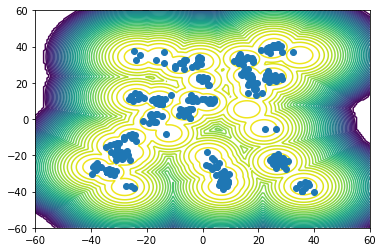

 25%|██▌       | 996/3906 [00:11<00:26, 110.99it/s]

Step 1000: Free energy 234.3654448127975 Log Normalizer estimate -0.4042831419518329


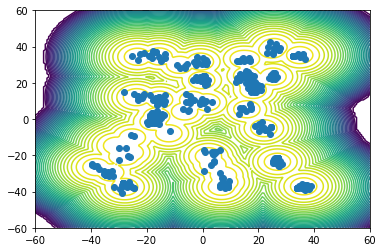

 51%|█████     | 1991/3906 [00:20<00:16, 119.05it/s]

Step 2000: Free energy 134.505249889322 Log Normalizer estimate -0.589293885135536


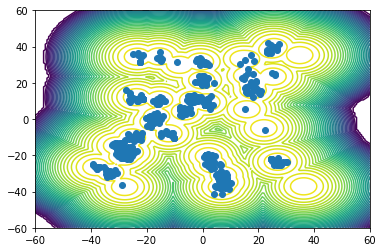

 77%|███████▋  | 3000/3906 [00:29<00:07, 119.14it/s]

Step 3000: Free energy 72.5340388016981 Log Normalizer estimate 0.776939138535198


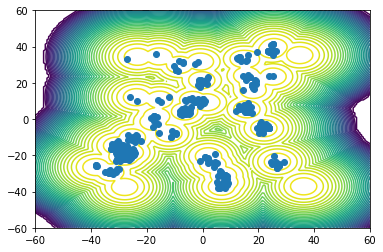

100%|██████████| 3906/3906 [00:37<00:00, 104.03it/s]


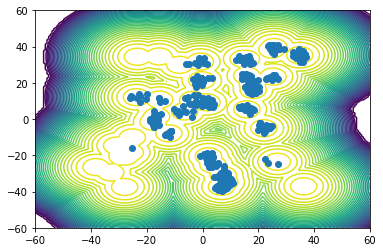

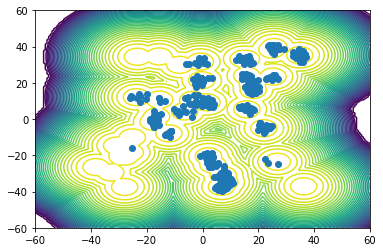

In [ ]:
results = run_experiment(exp_config)

## Include some HMC transitions
For the GMM problem we aim to make the initial flow + mcmc model not super good. With HMC the initial CRAFT model is already very good, but after training it drops some modes. 

In [ ]:
hmc_step_config = ConfigDict()
hmc_step_config.step_times = [0., 0.25, 0.5, 1.]
hmc_step_config.step_sizes = [0.15, 0.1, 0.1, 0.05]
exp_config.mcmc_config.hmc_step_config = hmc_step_config
exp_config.mcmc_config.use_jax_hmc = True

exp_config.mcmc_config.hmc_steps_per_iter = 2
exp_config.mcmc_config.hmc_num_leapfrog_steps = 10

exp_config.craft_num_iters = int(10_000_000/128/20) # Long enough to see results. 

In [ ]:
exp_config.mcmc_config

hmc_num_leapfrog_steps: 10
hmc_step_config:
  step_sizes:
  - 0.15
  - 0.1
  - 0.1
  - 0.05
  step_times:
  - 0.0
  - 0.25
  - 0.5
  - 1.0
hmc_steps_per_iter: 2
nuts_steps_per_iter: 0
rwm_step_config:
  step_sizes:
  - 5.0
  - 5.0
  step_times:
  - 0.0
  - 1.0
rwm_steps_per_iter: 1
slice_steps_per_iter: 0
use_jax_hmc: true

  0%|          | 0/3906 [00:00<?, ?it/s]

Step 0: Free energy 466.4350750884379 Log Normalizer estimate -0.18926651283134976


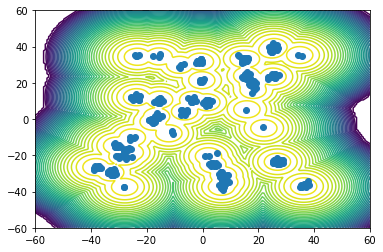

 26%|██▌       | 997/3906 [00:31<01:28, 32.84it/s]

Step 1000: Free energy 234.2873727988662 Log Normalizer estimate -0.2915225783260107


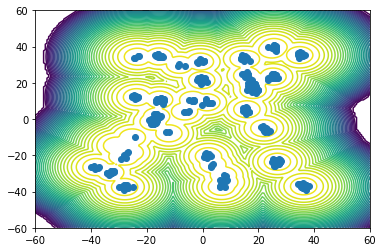

 51%|█████     | 1997/3906 [01:02<00:58, 32.88it/s]

Step 2000: Free energy 134.30672115521682 Log Normalizer estimate -0.456749331798882


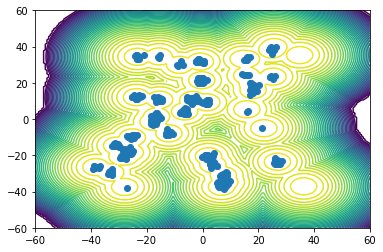

 77%|███████▋  | 2997/3906 [01:34<00:27, 32.87it/s]

Step 3000: Free energy 72.63425180721443 Log Normalizer estimate 0.7057456620709299


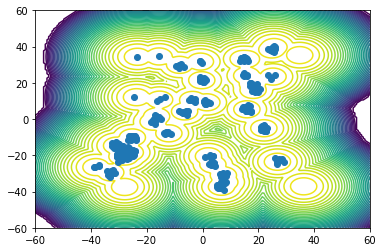

100%|██████████| 3906/3906 [02:02<00:00, 31.82it/s]


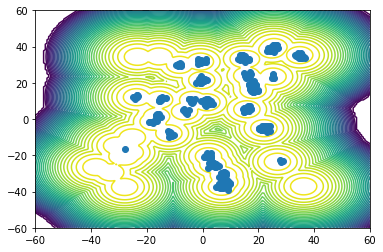

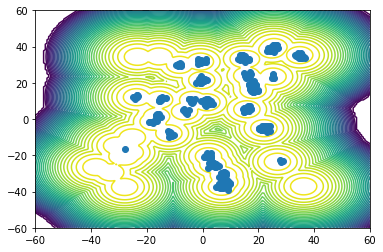

In [ ]:
results = run_experiment(exp_config)

# Increase metropolis step size, more steps
Try increase metropolis step size (makes mode discovery easier) and double the number of metropolis steps, but after training CRAFT still drops some modes. 

In [ ]:
exp_config.mcmc_config.rwm_step_config.step_sizes = [10.0, 10.0]  # constant step size
exp_config.mcmc_config.rwm_steps_per_iter = 2

In [ ]:
exp_config.mcmc_config

hmc_num_leapfrog_steps: 10
hmc_step_config:
  step_sizes:
  - 0.15
  - 0.1
  - 0.1
  - 0.05
  step_times:
  - 0.0
  - 0.25
  - 0.5
  - 1.0
hmc_steps_per_iter: 2
nuts_steps_per_iter: 0
rwm_step_config:
  step_sizes:
  - 10.0
  - 10.0
  step_times:
  - 0.0
  - 1.0
rwm_steps_per_iter: 2
slice_steps_per_iter: 0
use_jax_hmc: true

  0%|          | 0/3906 [00:00<?, ?it/s]

Step 0: Free energy 466.4421400887966 Log Normalizer estimate -0.2090999646310605


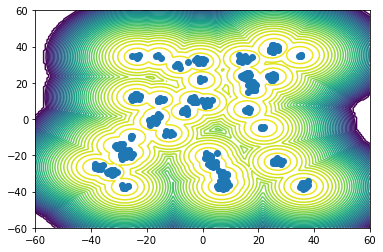

 26%|██▌       | 997/3906 [00:32<01:33, 31.01it/s]

Step 1000: Free energy 234.30171195980034 Log Normalizer estimate -0.29280893270788777


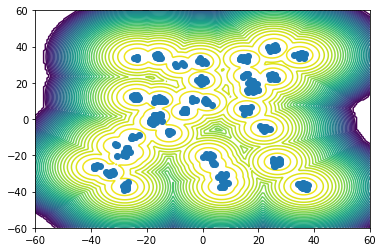

 51%|█████     | 1997/3906 [01:07<01:09, 27.34it/s]

Step 2000: Free energy 134.30872766611435 Log Normalizer estimate -0.46385414575885875


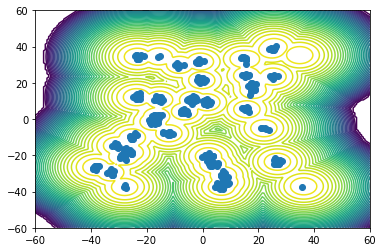

 77%|███████▋  | 2998/3906 [01:44<00:32, 27.58it/s]

Step 3000: Free energy 72.71406671145486 Log Normalizer estimate 0.6559024587330686


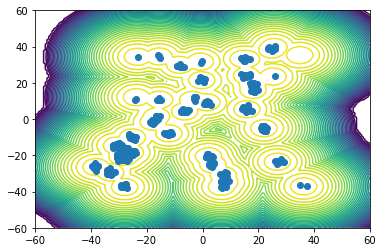

100%|██████████| 3906/3906 [02:23<00:00, 27.20it/s]


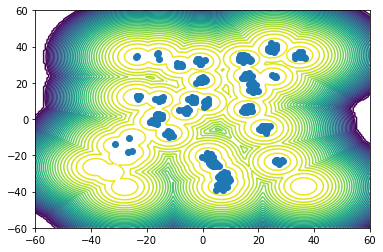

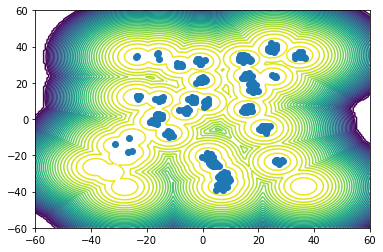

In [ ]:
results = run_experiment(exp_config)